In [1]:
import cv2
import numpy as np
import cooler
import pandas as pd 
import multiprocessing as mp
from scipy.signal import find_peaks, peak_prominences
import scipy
import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from joblib import Parallel, delayed

import scipy.sparse
import os
from scipy.stats import zscore
from matplotlib.lines import Line2D

In [2]:
def get_clr(path, resolution = '1000000'):
    clr = cooler.Cooler(path+'::/resolutions/'+resolution)
    return(clr)

def getBins(path,resolution = '1000000'):
	clr = get_clr(path,resolution = resolution)
	binsInfo = {}
	chroms = clr.chroms()["name"][:]
	for chrom in chroms:
		idxarray = np.where(clr.bins()["chrom"][:] == chrom)
		chromstart = idxarray[0][0]
		chromend = idxarray[0][-1]
		binsInfo[chrom] = [chromstart,chromend]
		#print chrom, (chromend - chromstart + 1)
	return clr,binsInfo

In [3]:
from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')
def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=0)

In [4]:
my_tad = pd.read_csv("/share/Data/hxie/project/202209/esc_xwliu/esc0615_version2/HiC_analysis/TAD/cluster/my_tad/my_tad_filtered_mod_tadE.csv")

# PileUp

In [5]:
def get_matrix(cluster_name, chrom = "chrX"):
    resolution = '20000'
    path = f"/share/Data/hxie/project/202209/esc_xwliu/esc1218/HiC_analysis/visual/bulkHiC_analysis/processed/mcools/"+cluster_name+".balanced.mcool"
    filename = os.path.basename(path)
    matrix, binsInfo = getBins(path, resolution)
    pat = matrix.matrix(balance=True).fetch(chrom+"(pat)")
    mat = matrix.matrix(balance=True).fetch(chrom+"(mat)")
    matrix = np.triu(pat) + np.tril(mat)
    # set c5 diagnal to Nan
    np.fill_diagonal(matrix, np.nan)
    return matrix

In [6]:
def pileup(matrix, my_tad): 
    mats = []
    
    for index, row in my_tad.iterrows():
        length = int(row['size']) 
        start = int(row['start']) 
        end = int(row['end'])     
        mati = matrix[start-length:end+length+1, start-length:end+length+1]
        mati = mati / np.nanmean(mati)
        # mati = (mati - np.nanmean(mati))/np.nanstd(mati)
        mats.append(mati)
    
    resize_mats = []
    for i in mats:
        resize_mats.append(cv2.resize(i, (99,99))) # change size
    pmat = np.nanmean(np.array(resize_mats), axis=0)
    return pmat

In [7]:
def fill_diag(mat):
    np.fill_diagonal(mat, np.nan)
    np.fill_diagonal(mat[1:, :-1], np.nan)
    np.fill_diagonal(mat[:-1, 1:], np.nan)
    # np.fill_diagonal(mat[2:, :-2], np.nan)
    # np.fill_diagonal(mat[:-2, 2:], np.nan)
    return mat

/tmp/ipykernel_64549/4204506432.py:16: RuntimeWarning: Mean of empty slice
  pmat = np.nanmean(np.array(resize_mats), axis=0)
/tmp/ipykernel_64549/3454598968.py:4: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("coolwarm").copy()
  cmap.set_bad(color='#bdbdbd')


([], [])

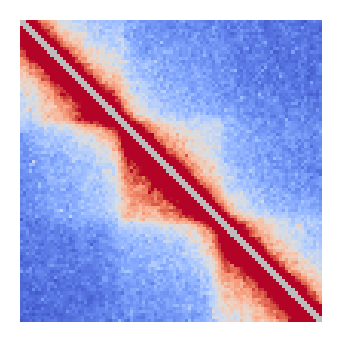

In [13]:
cluster = get_matrix("c5",chrom = "chrX")
plot = pileup(cluster, my_tad)
cmap = plt.cm.coolwarm
cmap.set_bad(color='#bdbdbd')

plot = fill_diag(plot)

plt.figure(figsize=(2, 2),dpi=200, facecolor='white')
plt.imshow(np.log2(plot+1),cmap=cmap, vmax = 1.5, vmin = 0)
# plt.colorbar()
# don't show the axes label
plt.axis('off')
plt.xticks([])
plt.yticks([])

# save the figure in svg
# plt.savefig("/share/Data/hxie/project/202209/esc_xwliu/esc0312_tidyup/fig2/figures/f2A_4_c4.svg", format="svg", bbox_inches='tight')

# calculate TAD score

In [9]:
def get_domain_score(amap, flank=1):
    c = amap.shape[0] / (flank * 2 + 1)
    assert int(c) == c
    c = int(c)
    central = np.nansum(amap[c:-c, c:-c])
    top = np.nansum(amap[:c, c:-c])
    right = np.nansum(amap[c:-c, -c:])
    return central / (top + right + central)

In [10]:
results = {}
chrom = "chrX"
# Loop over cluster names from c0 to c5
for i in range(6):
    cluster_name = f"c{i}"
    resolution = '20000'
    path = f"/share/Data/hxie/project/202209/esc_xwliu/esc1218/HiC_analysis/visual/bulkHiC_analysis/processed/mcools/{cluster_name}.balanced.mcool"
    filename = os.path.basename(path)
    
    matrix, binsInfo = getBins(path, resolution)
    pat = matrix.matrix(balance=True).fetch(chrom+"(pat)")
    mat = matrix.matrix(balance=True).fetch(chrom+"(mat)")
    
    pat_mean = pileup(pat, my_tad)
    mat_mean = pileup(mat, my_tad)

    pat_mean = fill_diag(pat_mean)
    mat_mean = fill_diag(mat_mean)

    pat_score = get_domain_score(pat_mean)
    mat_score = get_domain_score(mat_mean)
    
    results[cluster_name] = { 
        "pat_score": pat_score,
        "mat_score": mat_score
    }

# Optionally, you can process the results further or save them to a file.
print(results)

{'c0': {'pat_score': 0.6791863510189097, 'mat_score': 0.6877719834487686}, 'c1': {'pat_score': 0.6914945994890885, 'mat_score': 0.6920462018318357}, 'c2': {'pat_score': 0.6812472011611272, 'mat_score': 0.6822561331708368}, 'c3': {'pat_score': 0.6845113064540642, 'mat_score': 0.6534588250080314}, 'c4': {'pat_score': 0.6487194630865853, 'mat_score': 0.6894422205426685}, 'c5': {'pat_score': 0.6374721341600871, 'mat_score': 0.6916286199918853}}


In [11]:
pd.DataFrame(results)

,c0,c1,c2,c3,c4,c5
pat_score,0.679186,0.691495,0.681247,0.684511,0.648719,0.637472
mat_score,0.687772,0.692046,0.682256,0.653459,0.689442,0.691629


In [121]:
pd.DataFrame(results).to_csv("pileup_score.csv")